# Residual Networks: Exploring Standard vs Bottleneck Architectures using the MNIST Dataset

## Introduction

In this exercise, we will explore how **Residual Networks (ResNets)** enable efficient deep learning by using **skip connections** and **bottleneck blocks** to reduce computational cost without sacrificing model performance. Residual connections help combat the problem of **vanishing gradients** and make training deep networks feasible.

We will use the **MNIST dataset** — a small image dataset — to compare two types of convolutional residual blocks used in feature extraction:
1. A **standard residual block** with a single `3×3` convolution.  
2. A **bottleneck residual block** that uses a `1×1–3×3–1×1` structure to compress and expand feature maps efficiently.


### Model Overview

You will design and train two convolutional models:

- **Model 1:** Uses a **standard residual block** with Batch Normalization → ReLU → 3×3 Conv.  
- **Model 2:** Uses a **bottleneck residual block** with BatchNorm–ReLU–Convolution in a 1×1 → 3×3 → 1×1 pattern.

After training both models, you will:
- Compare **parameter efficiency** (total learnable parameters).  
- Evaluate and visualize **training performance** on the MNIST dataset.  

---

## **Stages**

1. **Import Necessary Libraries** – Load required Python and deep learning packages.  
2. **Download and Load the MNIST Dataset** – Explore its structure and format.  
3. **Preprocess and Prepare DataLoaders** – Normalize, resize, and split the dataset into training, validation, and test sets.  
4. **Visualize and Understand Data** – Plot a few samples and check label distribution to ensure data is correctly loaded.  
5. **Define and Train Models** – Implement both the **standard** and **bottleneck** residual networks, and train each under identical conditions.  
6. **Evaluate and Compare Models** – Measure accuracy, loss, and number of parameters; compare the results.  
7. **Visualize Outputs and Model Insights**

---

This notebook is divided into modular sections to help you understand the **architecture-level trade-offs** in deep learning models.  
Complete the code blocks marked with: BEGIN and END solution.


## 1. Import Necessary Libraries

In this section, we import the essential Python libraries required for building, training, and evaluating our convolutional residual networks.

We will use:
- **PyTorch** for model definition, training, and evaluation.  
- **Torchvision** for loading and transforming the MNIST dataset.  
- **Matplotlib** and **NumPy** for visualization and numerical operations.  
- **tqdm** for tracking training progress.

Make sure all required packages are installed before proceeding.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import time

# Check device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
skip_training = False

In [ ]:
# Do not delete this cell

## 2. Download and Load the MNIST Dataset

In this section, we will download the **MNIST** dataset, which contains **60,000 training** and **10,000 test** grayscale images of handwritten digits (0–9), each of size **28×28 pixels**.

We will:
- Use `torchvision.datasets.MNIST` to download and load the data.  
- Apply image transformations such as **tensor conversion** and **normalization** to ensure consistent model training.  

The images are normalized using the mean and standard deviation of the MNIST dataset:
- Mean = 0.1307  
- Std  = 0.3081


In [3]:
# Define transformations: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load training and test sets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


## 3. Preprocess and Prepare DataLoaders

Before training, let’s verify that our MNIST data is correctly loaded and preprocessed.

In this stage, we will:
- Check the **shape** and **value range** of sample tensors.  
- Optionally create a **validation set** (useful for model tuning).  

## Task: Create DataLoaders

In this task, you will create PyTorch DataLoaders for the training, validation, and test datasets.
Each DataLoader controls how data is batched and shuffled during model training and evaluation.

- Create a train_loader for the training dataset (train_dataset):
batch size: 64
- Create a test_loader for the test dataset (test_dataset):
batch size: 1000
- Create a val_loader for the validation dataset (val_dataset):
batch size: 1000

This ensures that the data pipeline is ready before defining the neural network architectures.


In [4]:
# Inspect one sample
example_data, example_label = train_dataset[0]
print(f"Sample image shape: {example_data.shape}")
print(f"Label: {example_label}")
print(f"Tensor value range: {example_data.min():.4f} to {example_data.max():.4f}")

# create a validation split (e.g., 10% of training set)
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DataLoaders
# YOUR CODE HERE
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1000,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")




Sample image shape: torch.Size([1, 28, 28])
Label: 5
Tensor value range: -0.4242 to 2.8215
Training samples: 54000
Validation samples: 6000
Test samples: 10000


In [ ]:
# Do not delete this cell

# 4. Visualize and Understand Data

Before building and training models, let's take a closer look at the MNIST dataset to confirm it was loaded correctly and understand its structure.

We will:
- Display a few sample digits from the training set.
- Check the image shape and value range.
- Plot the distribution of class labels.

This step ensures the data pipeline works as expected and helps you become familiar with the dataset before designing models.


In [5]:
# Inspect a single training sample
example_data, example_label = train_dataset[0]
print(f"Sample image shape: {example_data.shape}")
print(f"Label: {example_label}")
print(f"Tensor value range: {example_data.min():.4f} to {example_data.max():.4f}")


Sample image shape: torch.Size([1, 28, 28])
Label: 6
Tensor value range: -0.4242 to 2.8215


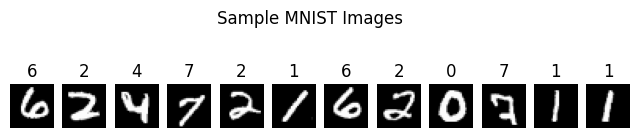

In [6]:
# Visualize a grid of sample digits
def show_sample_images(dataset, num_images=12):
    plt.figure(figsize=(8, 2))
    for i in range(num_images):
        img, label = dataset[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.suptitle("Sample MNIST Images")
    plt.show()

show_sample_images(train_dataset)


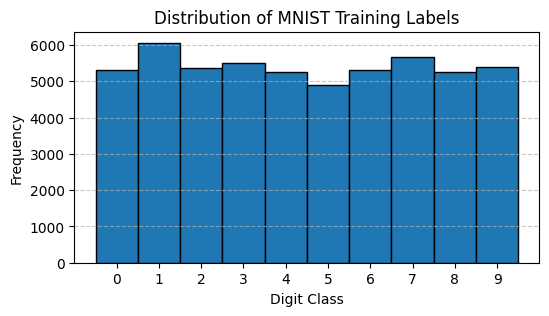

In [7]:
# Extract labels from the dataset
labels = [label for _, label in train_dataset]
plt.figure(figsize=(6, 3))
plt.hist(labels, bins=np.arange(11) - 0.5, edgecolor='black')
plt.title("Distribution of MNIST Training Labels")
plt.xlabel("Digit Class")
plt.ylabel("Frequency")
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 5. Model Definition and Training

In this section, we will define and train baseline and bottleneck model:

## Task: Implement Residual Blocks

### 1. StandardResidualBlock
Implement a **standard residual block**.  
The block should:
- Apply **Batch Normalization (BN)** on the input.
- Apply **ReLU activation**.
- Apply a **3×3 convolution** that: Preserves the number of channels, Preserves spatial resolution (**padding = 1**), Uses a learnable bias (**bias=True** is acceptable)
- Add a **skip connection** from the input to the output.

For a visual reference, see the provided residual block diagram.


Standard residual block


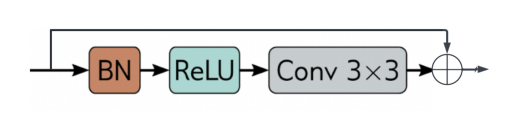

In [9]:
img = Image.open("Residual_block.png")
print("Standard residual block")
plt.imshow(img)
plt.axis("off")  # hide axes
plt.show()


In [12]:
# ---------- Standard Residual Block ----------
class StandardResidualBlock(nn.Module):

    def __init__(self, channels=128):
        super(StandardResidualBlock, self).__init__()
        # YOUR CODE HERE
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )

    def forward(self, x):
        # YOUR CODE HERE
        identity = x
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv(out)
        out = out + identity
        return out

## Task: Implement a Bottleneck Residual Block

Implement a bottleneck-style residual block.

Your implementation should:

- Use **three convolutional layers** arranged in a bottleneck structure
- Apply **Batch Normalization and ReLU activation before each convolution**
- **Reduce the channel dimensionality only in the intermediate representation**, and restore it before the residual addition
- **Preserve the spatial resolution** (height and width) of the input
- Include a **residual (skip) connection** that adds the input directly to the block output

Refer to the provided bottleneck residual block diagram for guidance on the structure.


Bottleneck residual block


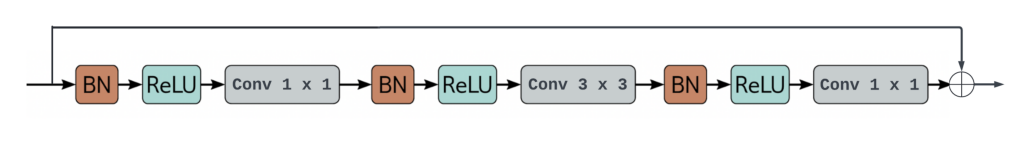

In [13]:
img = Image.open("Bottleneck_residual_block.png")
print("Bottleneck residual block")
plt.figure(figsize=(13, 10))   # make the display bigger (adjust numbers)
plt.imshow(img)
plt.axis("off")
plt.show()

In [16]:
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels=128, bottleneck_channels=32):
        super(BottleneckResidualBlock, self).__init__()
        # YOUR CODE HERE
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True
        )
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
              in_channels=bottleneck_channels,
              out_channels=bottleneck_channels,
              kernel_size=3,
              stride=1,
              padding=1,
              bias=True
          )
        self.bn3 = nn.BatchNorm2d(bottleneck_channels)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(
            in_channels=bottleneck_channels,
            out_channels=in_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True
        )

    def forward(self, x):

        # YOUR CODE HERE
        # Save input for skip connection
        identity = x

        # First BN-ReLU-Conv (compress: 128 → 32)
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        # Second BN-ReLU-Conv (process: 32 → 32)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        # Third BN-ReLU-Conv (expand: 32 → 128)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.conv3(out)

        # Add skip connection
        out = out + identity

        return out


In [17]:
# ---------- Full Model Wrapper ----------
class ResidualCNN(nn.Module):
    def __init__(self, use_bottleneck=False):
        super(ResidualCNN, self).__init__()
        self.use_bottleneck = use_bottleneck

        self.initial = nn.Conv2d(1, 128, kernel_size=3, padding=1)

        if use_bottleneck:
            self.res_block = BottleneckResidualBlock(128, 32)
        else:
            self.res_block = StandardResidualBlock(128)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        out = self.initial(x)
        out = self.res_block(out)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
# Do not delete this cell


In [ ]:
# Do not delete this cell


## Initialize Convolutional Layer Weights

This function iterates through all modules in the given model.  
For each convolutional layer (`nn.Conv2d`):  
- The weights are initialized using **Kaiming Normal Initialization** suitable for ReLU activations.  
- Biases, if present, are set to **0**.


In [18]:
# ---------- Initialize Weights for Conv Layers ----------
def initialize_conv_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [19]:

# Instantiate models
baseline_model = ResidualCNN(use_bottleneck=False).to(device)
bottleneck_model = ResidualCNN(use_bottleneck=True).to(device)

initialize_conv_weights(baseline_model)
initialize_conv_weights(bottleneck_model)


In [20]:
# Show model summaries
print("Baseline Residual Block:")
summary(baseline_model, (1, 28, 28))

Baseline Residual Block:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
       BatchNorm2d-2          [-1, 128, 28, 28]             256
              ReLU-3          [-1, 128, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]         147,584
StandardResidualBlock-5          [-1, 128, 28, 28]               0
 AdaptiveAvgPool2d-6            [-1, 128, 1, 1]               0
            Linear-7                   [-1, 10]           1,290
Total params: 150,410
Trainable params: 150,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.83
Params size (MB): 0.57
Estimated Total Size (MB): 4.41
----------------------------------------------------------------


In [21]:
print("\nBottleneck Residual Block:")
summary(bottleneck_model, (1, 28, 28))



Bottleneck Residual Block:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
       BatchNorm2d-2          [-1, 128, 28, 28]             256
              ReLU-3          [-1, 128, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,128
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]           4,224
BottleneckResidualBlock-11          [-1, 128, 28, 28]               0
AdaptiveAvgPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                   [-1, 10]           1,290
Total

## 5.1 Training Setup

Both models will be trained for a few epochs to compare their learning performance.

We will use:
- **Loss:** CrossEntropyLoss  
- **Optimizer:** Adam (learning rate = 1e-3)  
- **Metric:** Accuracy  

To ensure a fair comparison, both models will be trained on identical datasets and for the same number of epochs.

## Task: Implement Training Step

During training, the model learns by adjusting its parameters to minimize the loss between its predictions and the true labels. Each batch of data goes through the following steps:

- Move input images and labels to the appropriate device (CPU or GPU).  
- Clear the optimizer’s gradients from previous batches to avoid accumulation.  
- Perform a forward pass through the model to generate predictions.  
- Compute the loss between the model’s predictions and the ground-truth labels using the declared criterion.  
- Backpropagate the loss to calculate gradients with respect to the model parameters.  
- Update the model parameters using the optimizer.  
- Accumulate the batch loss to `total_loss` to later compute the average training loss for the epoch.  


In [22]:
def train_model(model, train_loader, val_loader, epochs=3, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_history, val_loss_history = [], []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
          # YOUR CODE HERE
          images = images.to(device)
          labels = labels.to(device)

          # Clear gradients from previous batch
          optimizer.zero_grad()

          # Forward pass: compute predictions
          outputs = model(images)

          # Compute loss
          loss = criterion(outputs, labels)

          # Backward pass: compute gradients
          loss.backward()

          # Update model parameters
          optimizer.step()

          # Accumulate batch loss
          total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)  # move images to GPU/CPU
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return train_loss_history, val_loss_history, val_acc_history


In [ ]:
# Do not delete this cell


## 5.2 Train Both Models

We will now train:
1. The **Baseline Residual Model** (standard 3×3 block)  
2. The **Bottleneck Residual Model** (1×1–3×3–1×1 block)


In [23]:
if not skip_training:
    print("Training Baseline Model...\n")
    base_train_loss, base_val_loss, base_acc = train_model(baseline_model, train_loader, val_loader, epochs=3)

    # Save baseline model
    torch.save({
        "model_state": baseline_model.state_dict(),
        "train_loss": base_train_loss,
        "val_loss": base_val_loss,
        "val_acc": base_acc,
    }, "baseline_model.pth")


    print("\nTraining Bottleneck Model...\n")
    bottle_train_loss, bottle_val_loss, bottle_acc = train_model(bottleneck_model, train_loader, val_loader, epochs=3)

    # Save bottleneck model
    torch.save({
        "model_state": bottleneck_model.state_dict(),
        "train_loss": bottle_train_loss,
        "val_loss": bottle_val_loss,
        "val_acc": bottle_acc,
    }, "bottleneck_model.pth")


Training Baseline Model...

Epoch [1/3] | Train Loss: 1.4901 | Val Loss: 1.3035 | Val Acc: 50.65%
Epoch [2/3] | Train Loss: 1.2954 | Val Loss: 1.2438 | Val Acc: 52.30%
Epoch [3/3] | Train Loss: 1.2523 | Val Loss: 1.1960 | Val Acc: 54.47%

Training Bottleneck Model...

Epoch [1/3] | Train Loss: 1.1606 | Val Loss: 0.7885 | Val Acc: 73.28%
Epoch [2/3] | Train Loss: 0.6094 | Val Loss: 0.5441 | Val Acc: 83.50%
Epoch [3/3] | Train Loss: 0.4262 | Val Loss: 0.5025 | Val Acc: 84.27%


In [ ]:
# Do not delete this cell


# 6. Evaluation and Comparison

Now that both the **Baseline Residual Model** and **Bottleneck Residual Model** have been trained, we will evaluate and compare them on three key aspects:

1. **Accuracy** on the test set — to ensure both models perform well.
2. **Parameter Count** — to measure model complexity.
3. **Inference Time** — to estimate runtime efficiency (important for edge devices).



In [24]:

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()
    acc = 100. * correct / total
    inference_time = (end_time - start_time)
    return acc, inference_time


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [25]:
# Evaluate both models
baseline_acc, baseline_time = evaluate_model(baseline_model, test_loader)
bottleneck_acc, bottleneck_time = evaluate_model(bottleneck_model, test_loader)

# Count parameters
baseline_params = count_parameters(baseline_model)
bottleneck_params = count_parameters(bottleneck_model)


results = pd.DataFrame({
    "Model": ["Baseline Residual", "Bottleneck Residual"],
    "Parameters": [baseline_params, bottleneck_params],
    "Test Accuracy (%)": [baseline_acc, bottleneck_acc],
    "Inference Time (s)": [baseline_time, bottleneck_time]
})

display(results)


,Model,Parameters,Test Accuracy (%),Inference Time (s)
0,Baseline Residual,150410,56.57,2.358743
1,Bottleneck Residual,20554,85.41,2.139724


In [ ]:
# Do not delete this cell


# 7. Visualizing Outputs and Model Insights

To build a deeper understanding of residual networks, we will visualize both **training behavior** and **feature activations**.

We focus on:
1. **Training Curves** – How loss and accuracy evolve over time.
2. **Feature Map Visualizations** – What patterns each network learns in early convolutional layers.
3. **Comparison of Feature Representations** – Differences between the standard and bottleneck residual designs.

Baseline Model Predictions:


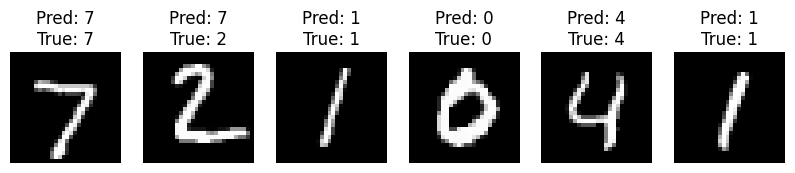

Bottleneck Model Predictions:


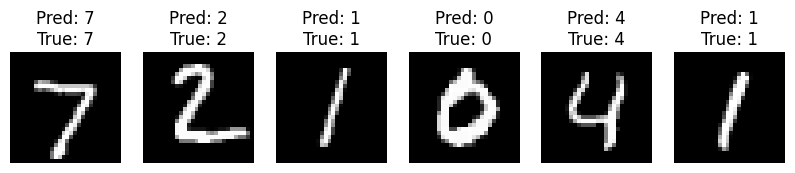

In [26]:

def visualize_predictions(model, test_loader, num_images=6):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        plt.axis('off')
    plt.show()


print("Baseline Model Predictions:")
visualize_predictions(baseline_model, test_loader)

print("Bottleneck Model Predictions:")
visualize_predictions(bottleneck_model, test_loader)


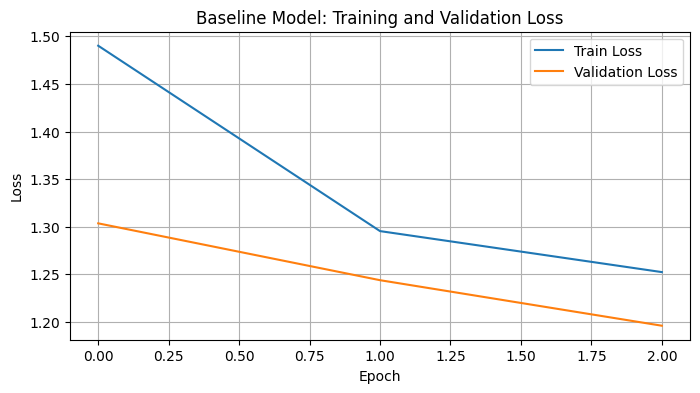

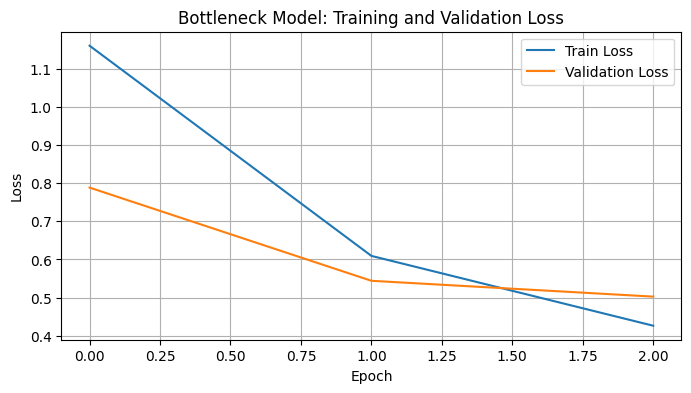

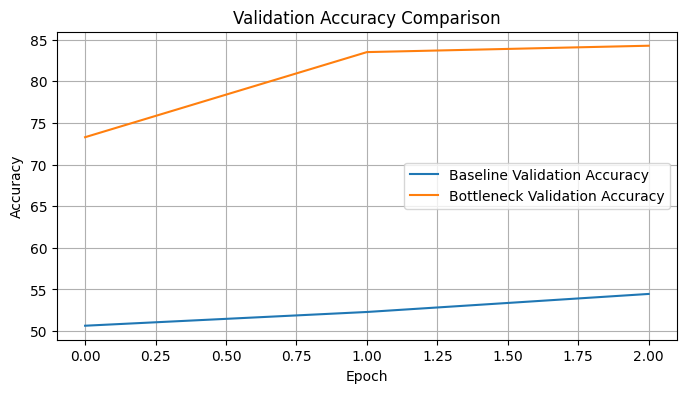

In [27]:
# Plot Baseline Model: Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(base_train_loss, label="Train Loss")
plt.plot(base_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model: Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Bottleneck Model: Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(bottle_train_loss, label="Train Loss")
plt.plot(bottle_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Bottleneck Model: Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy Comparison
plt.figure(figsize=(8, 4))
plt.plot(base_acc, label="Baseline Validation Accuracy")
plt.plot(bottle_acc, label="Bottleneck Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()




Feature maps - Baseline Model:


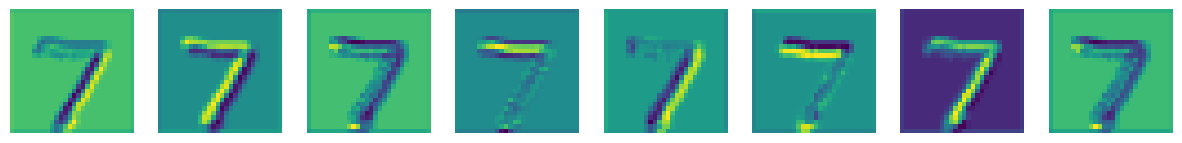

Feature maps - Bottleneck Model:


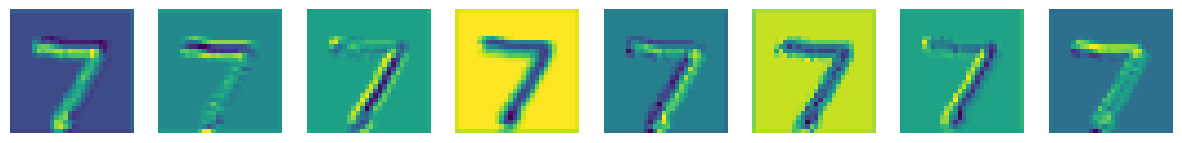

In [28]:
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        # Forward pass only through the first conv layer
        if hasattr(model, 'initial'):
            features = model.initial(image.unsqueeze(0).to(device))
        else:
            raise ValueError("Model does not have an 'initial' layer.")

    # Take first few channels to visualize
    num_maps = min(8, features.shape[1])
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 2))
    for i in range(num_maps):
        axes[i].imshow(features[0, i].cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
    plt.show()

# Example visualization
sample_img, _ = test_dataset[0]
print("Feature maps - Baseline Model:")
visualize_feature_maps(baseline_model, sample_img)

print("Feature maps - Bottleneck Model:")
visualize_feature_maps(bottleneck_model, sample_img)
